# Modelo de IA. 

## Red Neuronal Recurente con GRU (Gated Recurrent Units)

Como veiamos en clase, GRU es una vairante de las redes recurrentes que es más eficiente que LSTM en ciertas tareas,
ya que tienen menos parámetros y usa puertas para manejar la memoria de corto y largo plazo.

In [ ]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Modelo secuencial
from tensorflow.keras.layers import GRU, Dense, Embedding # Capa de embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report # Matriz de confusión
from tensorflow.keras.callbacks import EarlyStopping # Early stopping


# Es necesario instalar la librería openpyxl para leer archivos Excel, ejecutando el siguiente comando:
# !pip install openpyxl

# Cargamos el dataset desde la URL de GitHub
news = pd.read_excel(
    'https://github.com/Pelli223/aiiotFakeNews/raw/06f20a2ba1bdcbf89042f7a1348af6d7893fc300/datos_limpios_estandarizados.xlsx',
    engine='openpyxl'
)

# Verificamos si el dataset se ha cargado correctamente

if news is not None:
    print("Dataset cargado correctamente.")
    print("Número de filas en el dataset:", len(news))
    print("Número de columnas en el dataset:", len(news.columns))   
else:
    print("Error al cargar el dataset.")
    exit

Dataset cargado correctamente.
Número de filas en el dataset: 18045
Número de columnas en el dataset: 23


In [2]:
# Preprocesamiento del texto

# Tokenizar los títulos y texto
# Aseguramos que los valores en las columnas sean cadenas de texto
news["contenido"] = news["title"].astype(str) + " " + news["text"].astype(str) # Concatenamos el título y el texto
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Creamos el tokenizador
tokenizer.fit_on_texts(news["contenido"]) # Ajustamos el tokenizador a los títulos y texto concatenados
news["contenido"]

# Convertimos el texto a secuencias
secuencias = tokenizer.texts_to_sequences(news["contenido"]) # Convertimos el texto a secuencias
secuencias = pad_sequences(secuencias, maxlen=200, padding='post', truncating='post') # Rellenamos las secuencias para que tengan la misma longitud

# Seleccionamos las columnas categoricas
categorias = news.iloc[:, 3:17].values # Categorías y fuentes (16 columnas).

# Fusionar datos de texto y categorías
final = np.hstack((secuencias, categorias)) # Fusionamos las secuencias y las categorías

# Usamos el word_count y chart_count como características numéricas
wc = news["word_count"].values.reshape(-1, 1) # Contador de palabras
cc = news["char_count"].values.reshape(-1, 1) # Contador de gráficos

# Agregamos estas caracteristicas al conjunto de datos
final = np.hstack((final, wc, cc)) # Fusionamos las secuencias y las categorías

# Extraemos los valores de año, mes y día
fecha = news[['year', 'month', 'day']].values # Extraemos los valores de año, mes y día

# Fusionamos los datos de fecha con el resto de los datos
final = np.hstack((final, fecha)) # Fusionamos los datos de fecha con el resto de los datos


In [ ]:
# Dividimos el dataset en entrenamiento y prueba
# 80% entrenamiento, 20% prueba

# La columna "label" es nuestra variable objetivo
y = news["label"].values # Variable objetivo

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2, random_state=42) # Dividimos el dataset en entrenamiento y prueba. test_size=0.2 significa que el 20% del dataset se usará para prueba y el 80% para entrenamiento

Epoch 1/35


c:\Users\aleja\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


452/452 ━━━━━━━━━━━━━━━━━━━━ 211s 454ms/step - accuracy: 0.5045 - loss: 0.6939 - val_accuracy: 0.5079 - val_loss: 0.6927
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 976s 2s/step - accuracy: 0.5142 - loss: 0.6928 - val_accuracy: 0.5085 - val_loss: 0.6928
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 298s 659ms/step - accuracy: 0.5556 - loss: 0.6853 - val_accuracy: 0.5121 - val_loss: 0.7007
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 325s 721ms/step - accuracy: 0.5783 - loss: 0.6742 - val_accuracy: 0.5037 - val_loss: 0.7019
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 87s 193ms/step - accuracy: 0.5869 - loss: 0.6692 - val_accuracy: 0.5054 - val_loss: 0.7147
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 108s 238ms/step - accuracy: 0.5929 - loss: 0.6622 - val_accuracy: 0.5048 - val_loss: 0.7124


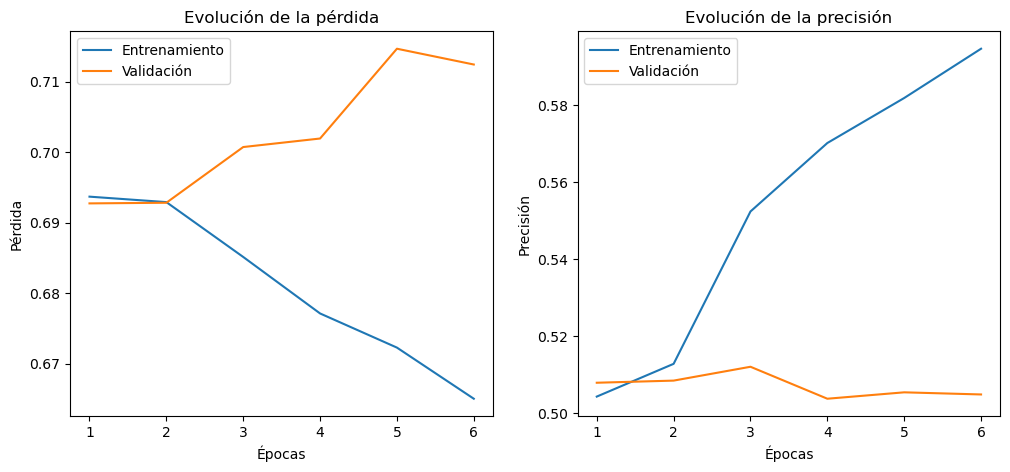

In [ ]:
modelo = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=secuencias.shape[1]), 
    GRU(100,activation='tanh'), 
    Dense(32, activation='relu'), # Procesa categorías y fuentes
    Dense(1, activation='sigmoid') # Capa de salida. Salida binaria (noticia falsa o no)
]) # Modelo secuencial con una capa de embedding, una capa GRU y dos capas densas

# Compilamos el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compilamos el modelo con el optimizador Adam y la función de pérdida binary_crossentropy

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping para evitar el sobreajuste y un procesamiento inecesario. Monitoriza la pérdida de validación y restaura los mejores pesos si no hay mejora en 5 épocas

# Entrenamos el modelo
historial=modelo.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop]) # Entrenamos el modelo con 35 épocas y tamaño de lote de 32

# Obtener los datos de pérdida y precisión
epochs = range(1, len(historial.history['loss']) + 1)

# Gráfico de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, historial.history['loss'], label='Entrenamiento')
plt.plot(epochs, historial.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial.history['accuracy'], label='Entrenamiento')
plt.plot(epochs, historial.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la precisión')
plt.legend()

plt.show()


In [5]:
# Evaluamos el modelo usando el conjunto de prueba
accuracy = modelo.evaluate(secuencias, news["label"])[1] # Evaluamos el modelo usando el conjunto de prueba
# Imprimimos la precisión del modelo
print(f"Precisión del modelo con todas las columnas y GRU: {accuracy:.2f}") 

564/564 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.5076 - loss: 0.6931
Precisión del modelo con todas las columnas y GRU: 0.50


In [ ]:
# Testamos el modelo con un nuevo texto. Noticia falsa que hemos creado
nuevo_texto = "El presidente de la EEUU, Joe Biden, anunció hoy nuevas medidas para combatir el cambio climático."

# Convertimos el nuevo texto a secuencias
secuenca = tokenizer.texts_to_sequences([nuevo_texto]) # Convertimos el texto a secuencias
secuencia_padded = pad_sequences(secuenca, maxlen=200, padding='post', truncating='post') # Rellenamos la secuencia para que tenga la misma longitud

## Supongamos que pertenece a la categoría "Política" y es de "CNN"
nuevas_caracteristicas = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 200, 1500]])  # Simulación de valores

# Concatenamos la secuencia con las nuevas características
entrada_final = np.hstack((secuencia_padded, nuevas_caracteristicas)) # Fusionamos la secuencia y las nuevas características

# Realizamos la predicción
predicciones = modelo.predict(entrada_final) # Predecimos el nuevo texto
print(f"Predicción para el nuevo texto: {predicciones[0][0]:.2f}") # Mostramos la predicción
# Mostramos la predicción

# convertir la predicción a una etiqueta
Etiqueta = "Noticia falsa" if predicciones[0][0] > 0.4 else "Noticia verdadera"

print(f"Esta es una {Etiqueta}") # Mostramos la etiqueta

# Convertir las probabilidades en etiquetas binarias (0 = verdadero, 1 = falso)
predicciones_binario = np.where(predicciones >= 0.4, 1, 0)

# Evaluar el modelo en el conjunto de prueba
predicciones_test = modelo.predict(X_test) # Predecimos el conjunto de prueba
predicciones_binario_test = np.where(predicciones_test >= 0.4, 1, 0) # Convertimos las predicciones a etiquetas binarias
# Convertimos las predicciones a etiquetas binarias
matriz_confusion = confusion_matrix(y_test, predicciones_binario_test) # Matriz de confusión
print("Matriz de confusión:")
print(matriz_confusion) # Mostramos la matriz de confusión
print("Explicación de la matriz de confusión:")
print("[TN, FP]")
print("[FN, TP]") # Mostramos la explicación de la matriz de confusión

# Generamos Classification Report
reporte_clasificacion = classification_report(y_test, predicciones_binario_test) # Reporte de clasificación
print ("Reporte de clasificación:")
print(reporte_clasificacion) # Mostramos el reporte de clasificación

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Predicción para el nuevo texto: 0.49
Esta es una Noticia falsa
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
Matriz de confusión:
[[   0 1846]
 [   0 1763]]
Explicación de la matriz de confusión:
[TN, FP]
[FN, TP]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1846
           1       0.49      1.00      0.66      1763

    accuracy                           0.49      3609
   macro avg       0.24      0.50      0.33      3609
weighted avg       0.24      0.49      0.32      3609



c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# IA Explicativa (XAI)
A continuación, utilizamos los sistemas explicativos para RNN-GRU:
- SHAP. Nos dirá qué características (como el texto, categoría, fuente, word_count, etc.) tienen más impacto en la predicción.
- LIME. Se utiliza para generar explicaciones locales para casos específicos.

PermutationExplainer explainer: 101it [1:18:45, 47.25s/it]                         
C:\Users\aleja\AppData\Local\Temp\ipykernel_21304\3647735865.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_gru, X_test_sample, feature_names=feature_names, max_display=10)


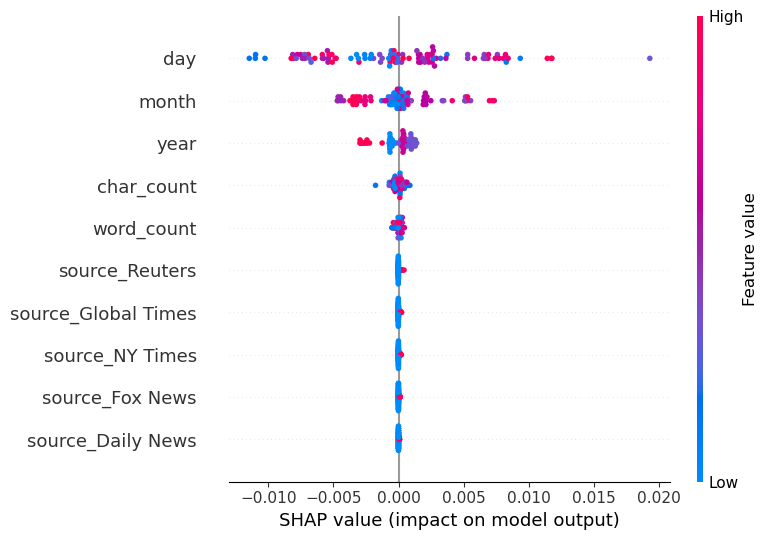

Ejecutamos Lime
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [19]:
# Aplicación de SHAP para explicar el modelo GRU
import shap
import lime
import lime.lime_tabular

#reducimos el tamaño del conjunto de datos para SHAP
sample_size = 100

X_test_sample = X_test[:sample_size] # Tomamos una muestra del conjunto de prueba


# Crear un objeto SHAP explainer para GRU
explainer_gru = shap.Explainer(modelo, X_test_sample)
shap_values_gru = explainer_gru(X_test_sample)

# Visualización de características más importantes para GRU
# Construir la lista de nombres de características para todas las columnas de X_test_sample
# Primero los nombres de los tokens
token_feature_names = [f"token_{i}" for i in range(secuencias.shape[1])]
# Luego los nombres de las columnas categóricas y numéricas
other_feature_names = list(news.columns[3:17]) + ["word_count", "char_count", "year", "month", "day"]
feature_names = token_feature_names + other_feature_names

shap.summary_plot(shap_values_gru, X_test_sample, feature_names=feature_names, max_display=10)

print ("Ejecutamos Lime")

# Aplicación de LIME para explicar el modelo GRU
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                        feature_names=feature_names, # Usamos los nombres correctos de las características
                                                        mode='classification')

idx = 10 # Índice de la instancia a explicar (ajustado para evitar IndexError)

# Asegurarse de que idx esté dentro del rango de X_test
if idx < len(X_test):
    # LIME espera una función que devuelva probabilidades para ambas clases
    def predict_proba_lime(x):
        p = modelo.predict(x)
        return np.hstack([1 - p, p])

    exp_gru = explainer_lime.explain_instance(X_test[idx], predict_proba_lime, num_features=5)
    exp_gru.show_in_notebook(show_table=True, show_all=False) # Mostrar la explicación en el cuaderno
else:
    print(f"El índice idx={idx} está fuera del rango de X_test (tamaño={len(X_test)}).")


In [22]:
# A continuación, vamos a ver qué palabras se corresponden con los tokens 8, 104 y 152.
word_index = tokenizer.word_index # Obtenemos el índice de las palabras

# Buscamos qué palabra corresponde a los tokens 8, 104 y 152
palabra_asociada = [k for k,v in word_index.items() if v == 8]
if palabra_asociada:
    print(f"El token 8 corresponde a la palabra: {palabra_asociada[0]}")


palabra_asociada = [k for k,v in word_index.items() if v == 104]
if palabra_asociada:
    print(f"El token 104 corresponde a la palabra: {palabra_asociada[0]}")

palabra_asociada = [k for k,v in word_index.items() if v == 152]
if palabra_asociada:
    print(f"El token 152 corresponde a la palabra: {palabra_asociada[0]}")

El token 8 corresponde a la palabra: factor
El token 104 corresponde a la palabra: international
El token 152 corresponde a la palabra: enough


# Utilizamos ahora la técnica de división # KFold Cross Validation, con K = 5, para GRU.

In [13]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential # Modelo secuencial
from tensorflow.keras.layers import GRU, Dense, Embedding # Capa de embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report # Matriz de confusión
from tensorflow.keras.callbacks import EarlyStopping # Early stopping

# Cargamos el dataset que vamos a utilizar

# Es necesario instalar la librería openpyxl para leer archivos Excel, ejecutando el siguiente comando:
# !pip install openpyxl

# Cargamos el dataset desde la URL de GitHub
news = pd.read_excel(
    'https://github.com/Pelli223/aiiotFakeNews/raw/06f20a2ba1bdcbf89042f7a1348af6d7893fc300/datos_limpios_estandarizados.xlsx',
    engine='openpyxl'
)

# Verificamos si el dataset se ha cargado correctamente

if news is not None:
    print("Dataset cargado correctamente.")
    print("Número de filas en el dataset:", len(news))
    print("Número de columnas en el dataset:", len(news.columns))   
else:
    print("Error al cargar el dataset.")
    exit

Dataset cargado correctamente.
Número de filas en el dataset: 18045
Número de columnas en el dataset: 23


In [15]:
# Preprocesamiento del texto

# Tokenizar los títulos y texto
# Aseguramos que los valores en las columnas sean cadenas de texto
news["contenido"] = news["title"].astype(str) + " " + news["text"].astype(str) # Concatenamos el título y el texto
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Creamos el tokenizador
tokenizer.fit_on_texts(news["contenido"]) # Ajustamos el tokenizador a los títulos y texto concatenados
news["contenido"]

# Convertimos el texto a secuencias
secuencias = tokenizer.texts_to_sequences(news["contenido"]) # Convertimos el texto a secuencias
secuencias = pad_sequences(secuencias, maxlen=200, padding='post', truncating='post') # Rellenamos las secuencias para que tengan la misma longitud

# Seleccionamos las columnas categoricas
categorias = news.iloc[:, 3:17].values # Categorías y fuentes (16 columnas).

# Fusionar datos de texto y categorías
final = np.hstack((secuencias, categorias)) # Fusionamos las secuencias y las categorías

# Usamos el word_count y chart_count como características numéricas
wc = news["word_count"].values.reshape(-1, 1) # Contador de palabras
cc = news["char_count"].values.reshape(-1, 1) # Contador de gráficos

# Agregamos estas caracteristicas al conjunto de datos
final = np.hstack((final, wc, cc)) # Fusionamos las secuencias y las categorías

# Extraemos los valores de año, mes y día
fecha = news[['year', 'month', 'day']].values # Extraemos los valores de año, mes y día

# Fusionamos los datos de fecha con el resto de los datos
final = np.hstack((final, fecha)) # Fusionamos los datos de fecha con el resto de los datos

c:\Users\aleja\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 143s 282ms/step - accuracy: 0.4940 - loss: 0.6937 - val_accuracy: 0.4891 - val_loss: 0.6941
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 136s 268ms/step - accuracy: 0.4985 - loss: 0.6936 - val_accuracy: 0.5040 - val_loss: 0.6930
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 185s 409ms/step - accuracy: 0.5528 - loss: 0.6883 - val_accuracy: 0.5181 - val_loss: 0.6947
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 127s 280ms/step - accuracy: 0.5757 - loss: 0.6755 - val_accuracy: 0.5148 - val_loss: 0.6973
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 151s 334ms/step - accuracy: 0.5846 - loss: 0.6722 - val_accuracy: 0.4963 - val_loss: 0.7037
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 156s 345ms/step - accuracy: 0.6142 - loss: 0.6574 - val_accuracy: 0.4993 - val_loss: 0.7190
Epoch 7/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 191s 422ms/step - accuracy: 0.6356 - loss: 0.6393 - val_accuracy: 0.5065 - val_loss: 0.7468


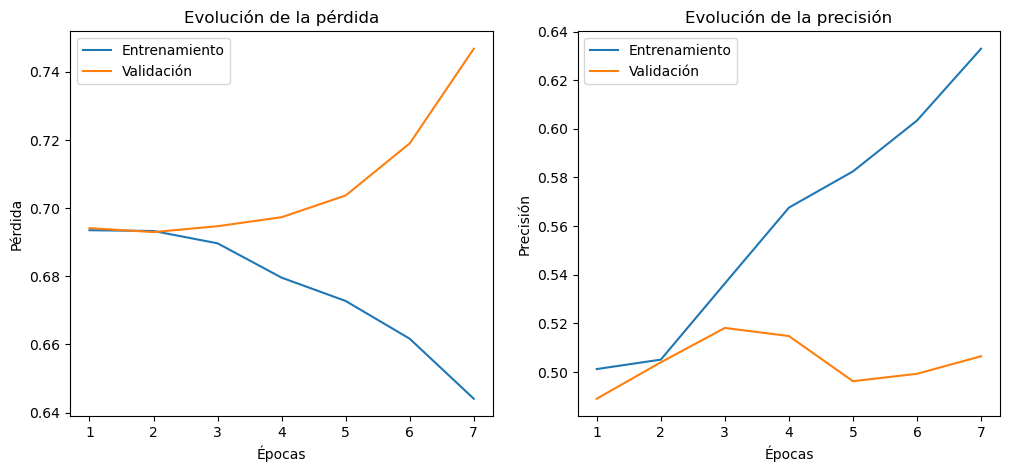

Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 186s 355ms/step - accuracy: 0.4847 - loss: 0.6935 - val_accuracy: 0.4927 - val_loss: 0.6939
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 278s 524ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.5024 - val_loss: 0.6939
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 403s 835ms/step - accuracy: 0.5615 - loss: 0.6859 - val_accuracy: 0.4957 - val_loss: 0.6984
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 174s 385ms/step - accuracy: 0.5825 - loss: 0.6744 - val_accuracy: 0.4943 - val_loss: 0.7056
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 307s 677ms/step - accuracy: 0.5956 - loss: 0.6636 - val_accuracy: 0.5029 - val_loss: 0.7072
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 140s 309ms/step - accuracy: 0.6052 - loss: 0.6589 - val_accuracy: 0.4976 - val_loss: 0.7161
Epoch 7/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 121s 266ms/step - accuracy: 0.6112 - loss: 0.6503 - val_accuracy: 0.4924 - val_loss: 0.7396


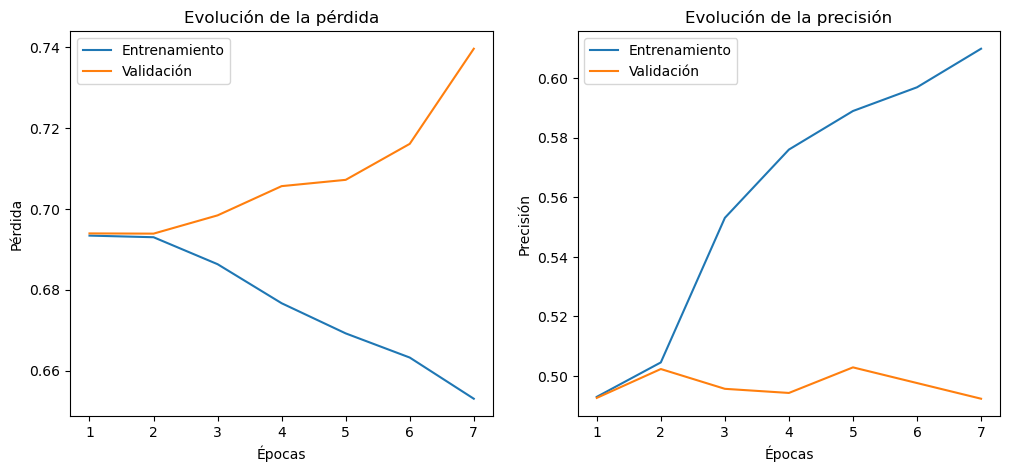

Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.5015 - val_loss: 0.6932
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 545s 1s/step - accuracy: 0.5304 - loss: 0.6915 - val_accuracy: 0.4954 - val_loss: 0.6959
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 101s 222ms/step - accuracy: 0.5663 - loss: 0.6794 - val_accuracy: 0.4979 - val_loss: 0.6992
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 68s 151ms/step - accuracy: 0.5850 - loss: 0.6717 - val_accuracy: 0.4935 - val_loss: 0.7137
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 78s 172ms/step - accuracy: 0.5809 - loss: 0.6682 - val_accuracy: 0.4974 - val_loss: 0.7185
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 103s 226ms/step - accuracy: 0.6041 - loss: 0.6595 - val_accuracy: 0.4927 - val_loss: 0.7190


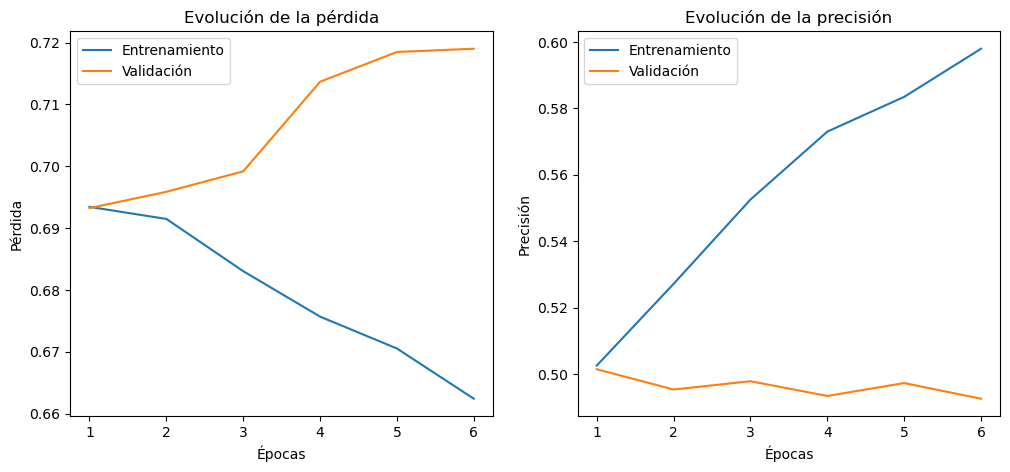

Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.4949 - loss: 0.6936 - val_accuracy: 0.4915 - val_loss: 0.6932
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step - accuracy: 0.5086 - loss: 0.6932 - val_accuracy: 0.4938 - val_loss: 0.6931
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 90s 200ms/step - accuracy: 0.5477 - loss: 0.6864 - val_accuracy: 0.4976 - val_loss: 0.6999
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step - accuracy: 0.5785 - loss: 0.6762 - val_accuracy: 0.5010 - val_loss: 0.7042
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 104s 231ms/step - accuracy: 0.5915 - loss: 0.6666 - val_accuracy: 0.4902 - val_loss: 0.7150
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 109s 241ms/step - accuracy: 0.5930 - loss: 0.6683 - val_accuracy: 0.5007 - val_loss: 0.7231
Epoch 7/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 209ms/step - accuracy: 0.6081 - loss: 0.6552 - val_accuracy: 0.4888 - val_loss: 0.7226


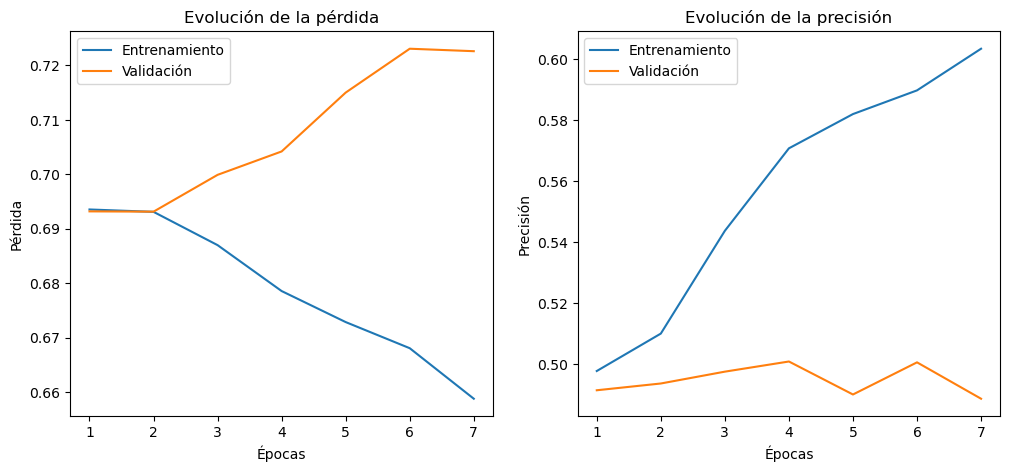

Epoch 1/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 111s 235ms/step - accuracy: 0.4984 - loss: 0.6934 - val_accuracy: 0.4868 - val_loss: 0.6935
Epoch 2/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 99s 219ms/step - accuracy: 0.5198 - loss: 0.6924 - val_accuracy: 0.4993 - val_loss: 0.6950
Epoch 3/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 97s 216ms/step - accuracy: 0.5605 - loss: 0.6850 - val_accuracy: 0.4979 - val_loss: 0.7053
Epoch 4/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 96s 213ms/step - accuracy: 0.5857 - loss: 0.6714 - val_accuracy: 0.5010 - val_loss: 0.7111
Epoch 5/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 135s 298ms/step - accuracy: 0.6049 - loss: 0.6600 - val_accuracy: 0.4952 - val_loss: 0.7216
Epoch 6/35
452/452 ━━━━━━━━━━━━━━━━━━━━ 164s 363ms/step - accuracy: 0.6257 - loss: 0.6477 - val_accuracy: 0.5001 - val_loss: 0.7326


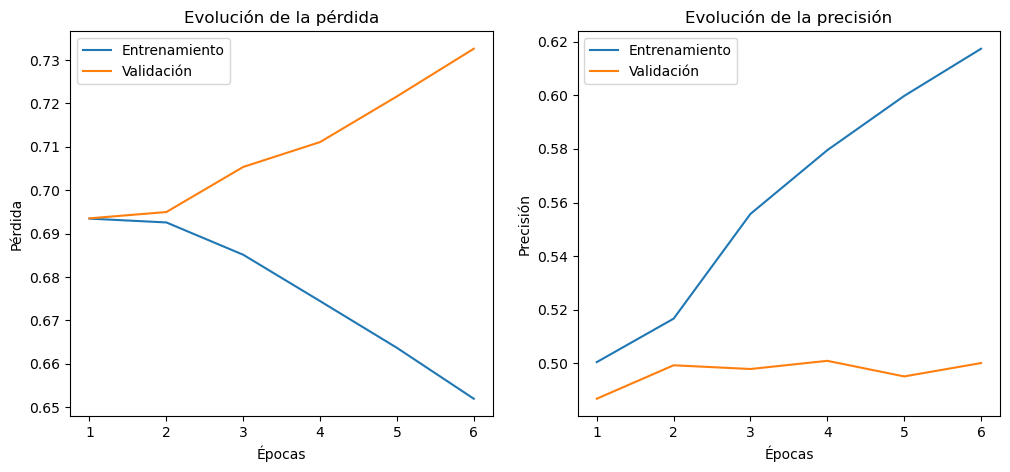

In [ ]:
from sklearn.model_selection import KFold

# Dividimos el dataset en entrenamiento y prueba. Usamos KFold para la validación cruzada
# con 5 pliegues

# Definimos el número de pliegues
K = 5 # se dividirá el dataset en 5 partes

kf = KFold(n_splits=K, shuffle=True, random_state=42) # Creamos el objeto KFold

# Lista para almacenar las precisiones de cada iteración
precisiones = [] # Lista para almacenar las precisiones de cada iteración

for train_index, test_index in kf.split(final): # Iteramos sobre los pliegues
    X_train, X_test = final[train_index], final[test_index] # Dividimos el dataset en entrenamiento y prueba
    y_train, y_test = news["label"].values[train_index], news["label"].values[test_index] # Dividimos el dataset en entrenamiento y prueba

    modelo = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=secuencias.shape[1]), 
        GRU(100,activation='tanh'), 
        Dense(32, activation='relu'), # Procesa categorías y fuentes
        Dense(1, activation='sigmoid') # Capa de salida. Salida binaria (noticia falsa o no)
    ]) # Modelo secuencial con una capa de embedding, una capa GRU y dos capas densas

    # Compilamos el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compilamos el modelo con el optimizador Adam y la función de pérdida binary_crossentropy

    earky_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Early stopping para evitar el sobreajuste

    # Entrenamos el modelo
    historial = modelo.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop]) # Entrenamos el modelo con 5 épocas y tamaño de lote de 32. bath_size=32 significa que se procesarán 32 muestras a la vez

    # Obtener los datos de pérdida y precisión
    epochs = range(1, len(historial.history['loss']) + 1)

    # Gráfico de pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, historial.history['loss'], label='Entrenamiento')
    plt.plot(epochs, historial.history['val_loss'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la pérdida')
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, historial.history['accuracy'], label='Entrenamiento')
    plt.plot(epochs, historial.history['val_accuracy'], label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Evolución de la precisión')
    plt.legend()

    plt.show()


    # Evaluamos el modelo con la partición de prueba	
    accuracy = modelo.evaluate(X_test, y_test)[1] # Evaluamos el modelo
    precisiones.append(accuracy) # Almacenamos la precisión


In [ ]:
# Calcular la precisión promedio
precision_final = np.mean(precisiones) # Calculamos la precisión promedio

print (precisiones)

print(f"Precisión promedio con K-Fold Cross Validation (K={K}): {precision_final:.2f}")

# Probamos el modelo con un nuevo texto. Noticia falsa que hemos creado
nuevo_texto = "Joe Biden, Presidente de EEUU, ha dimitido."

# Convertimos el nuevo texto a secuencias
secuencia = tokenizer.texts_to_sequences([nuevo_texto]) # Convertimos el texto a secuencias
secuencia_padded = pad_sequences(secuencia, maxlen=200, padding='post', truncating='post') # Rellenamos la secuencia para que tenga la misma longitud

# Supongamos que pertenece a la categoría "Política" y es de "CNN"
nuevas_caracteristicas = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 200, 1500]])  # Simulación de valores

# Concatenamos la secuencia con las nuevas características
entrada_final = np.hstack((secuencia_padded, nuevas_caracteristicas)) # Fusionamos la secuencia y las nuevas características

# Realizamos la predicción
predicciones = modelo.predict(entrada_final) # Predecimos el nuevo texto
print(f"Predicción para el nuevo texto: {predicciones[0][0]:.2f}") # Mostramos la predicción

# convertir la predicción a una etiqueta
Etiqueta = "Noticia falsa" if predicciones[0][0] > 0.4 else "Noticia verdadera"

print(f"Esta es una {Etiqueta}") # Mostramos la etiqueta

# Convertir las probabilidades en etiquetas binarias (0 = verdadero, 1 = falso)
predicciones_binario = np.where(predicciones >= 0.4, 1, 0)

# Evaluar el modelo con el conjunto de prueba
predicciones_test = modelo.predict(X_test)
predicciones_test_binario = np.where(predicciones_test >= 0.4, 1, 0)
matriz_confusion = confusion_matrix(y_test, predicciones_test_binario)

# Convertimos las predicciones a etiquetas binarias
print("Matriz de confusión:")
print(matriz_confusion)
print("Explicación de la matriz de confusión:")
print("[TN, FP]")
print("[FN, TP]")

# Generamos Classification Report
reporte_clasificacion = classification_report(y_test, predicciones_test_binario)
print("Reporte de clasificación:")
print(reporte_clasificacion)

[]
Precisión promedio con K-Fold Cross Validation (K=5): nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

c:\Users\aleja\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aleja\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicción para el nuevo texto: 0.50
Esta es una Noticia falsa
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
Matriz de confusión:
[[   0 1809]
 [   0 1800]]
Explicación de la matriz de confusión:
[TN, FP]
[FN, TP]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1809
           1       0.50      1.00      0.67      1800

    accuracy                           0.50      3609
   macro avg       0.25      0.50      0.33      3609
weighted avg       0.25      0.50      0.33      3609



c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aleja\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
